In [1]:
## Standard libraries
import os
import math
import numpy as np
import time

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.auto import tqdm

In [2]:
import jax
import jax.numpy as jnp
print("Using jax", jax.__version__)

Using jax 0.3.17


In [3]:
a = jnp.zeros((2, 5), dtype=jnp.float32)
print(a)

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [4]:
b = jnp.arange(6)
print(b)

[0 1 2 3 4 5]


In [5]:
# check class of creaed array
b.__class__

jaxlib.xla_extension.DeviceArray

In [6]:
# Show device
b.device()


GpuDevice(id=0, process_index=0)

In [7]:
# change device of array:
b_cpu = jax.device_get(b)
print(b_cpu.__class__)
# change back to gpu
b_gpu = jax.device_put(b_cpu)
print(b_gpu.__class__)

<class 'numpy.ndarray'>
<class 'jaxlib.xla_extension.DeviceArray'>


In [8]:
# get available device
jax.devices()

[GpuDevice(id=0, process_index=0)]

In [9]:
b_new = b.at[0].set(1)
print('Orignal array', b)
print('Change array: ', b_new)


Orignal array [0 1 2 3 4 5]
Change array:  [1 1 2 3 4 5]


In [10]:
def simple_graph(x):
  x = x + 2
  x = x**2
  x = x+3
  y = x.mean()
  return y

inp = jnp.arange(3, dtype=jnp.float32)
print("input", inp)
print('output', simple_graph(inp))

input [0. 1. 2.]
output 12.666667


In [11]:
jax.make_jaxpr(simple_graph)(inp)

{ lambda ; a:f32[3]. let
    b:f32[3] = add a 2.0
    c:f32[3] = integer_pow[y=2] b
    d:f32[3] = add c 3.0
    e:f32[] = reduce_sum[axes=(0,)] d
    f:f32[] = div e 3.0
  in (f,) }

In [12]:
# function with side effect
global_list = []

def norm(x):
  global_list.append(x)
  x = x**2
  n = x.sum()
  n = jnp.sqrt(n)
  return n

jax.make_jaxpr(norm)(inp)

{ lambda ; a:f32[3]. let
    b:f32[3] = integer_pow[y=2] a
    c:f32[] = reduce_sum[axes=(0,)] b
    d:f32[] = sqrt c
  in (d,) }

In [13]:
grad_function = jax.grad(simple_graph)
gradients = grad_function(inp)
print('Gradient', gradients)

Gradient [1.3333334 2.        2.6666667]


In [14]:
# Print the representation of gradient function
jax.make_jaxpr(grad_function)(inp)

{ lambda ; a:f32[3]. let
    b:f32[3] = add a 2.0
    c:f32[3] = integer_pow[y=2] b
    d:f32[3] = integer_pow[y=1] b
    e:f32[3] = mul 2.0 d
    f:f32[3] = add c 3.0
    g:f32[] = reduce_sum[axes=(0,)] f
    _:f32[] = div g 3.0
    h:f32[] = div 1.0 3.0
    i:f32[3] = broadcast_in_dim[broadcast_dimensions=() shape=(3,)] h
    j:f32[3] = mul i e
  in (j,) }

In [16]:
val_grad_function = jax.value_and_grad(simple_graph)
val_grad_function(inp)

(DeviceArray(12.666667, dtype=float32),
 DeviceArray([1.3333334, 2.       , 2.6666667], dtype=float32))

In [17]:
jitted_function = jax.jit(simple_graph)

In [20]:
rng = jax.random.PRNGKey(42)
# Create a new random subkey for generating new random values
rng, normal_rng = jax.random.split(rng)
large_input = jax.random.normal(normal_rng, (1000,))
# Run the jitted function once to start compilation
_ = jitted_function(large_input)

In [21]:
%%timeit
simple_graph(large_input).block_until_ready()

651 µs ± 96.4 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
%%timeit
jitted_function(large_input).block_until_ready()

61 µs ± 385 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [23]:
jitted_grad_function = jax.jit(grad_function)
_ = jitted_grad_function(large_input)  # Apply once to compile


In [24]:
%%timeit
grad_function(large_input).block_until_ready()

4.9 ms ± 243 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
%%timeit
jitted_grad_function(large_input).block_until_ready()

57.1 µs ± 555 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [26]:
try:
    import flax
except ModuleNotFoundError: # Install flax if missing
    !pip install --quiet flax
    import flax

from flax import linen as nn

     |████████████████████████████████| 180 kB 34.8 MB/s 
     |████████████████████████████████| 217 kB 71.7 MB/s 
     |████████████████████████████████| 145 kB 70.2 MB/s 
     |████████████████████████████████| 51 kB 6.6 MB/s 
     |████████████████████████████████| 85 kB 4.6 MB/s 


In [27]:
class MyModule(nn.Module):
  # Some dataclass attributes: hidden dimentsion
  # var name: vartype

  def setup(self):
    pass
  
  def __call__(self, x):
    # performe the calculation of the module
    pass

In [30]:
# Define classfier
class SimpleClassifier(nn.Module):
  num_hidden : int
  num_outputs: int
  
  def setup(self):
    self.linear1 = nn.Dense(features=self.num_hidden)
    self.linear2 = nn.Dense(features=self.num_outputs)

  def __call__(self, x):
    # Performe theh calculation
    x = self.linear1(x)
    x = nn.tanh(x)
    x = self.linear2(x)
    return x

In [31]:
# Compact classifier
class SimpleClassifierCompact(nn.Module):
  num_hidden : int
  num_outputs : int

  @nn.compact
  def __call__(self, x):
    x = nn.Dense(features=self.num_hidden)(x)
    x = nn.tanh(x)
    x = nn.Dense(features=self.num_outpupts)(x)
    return x

In [32]:
# Create an instance ofo this network
model = SimpleClassifier(num_hidden=8, num_outputs=1)
print(model)

SimpleClassifier(
    # attributes
    num_hidden = 8
    num_outputs = 1
)


In [33]:
rng, inp_rng, init_rng = jax.random.split(rng, 3)
inp = jax.random.normal(inp_rng, (8, 2))  # Batch size 8, input size 2
# Initialize the model
params = model.init(init_rng, inp)
print(params)

FrozenDict({
    params: {
        linear1: {
            kernel: DeviceArray([[-0.63638103,  0.03831888,  0.7264659 ,  0.581671  ,
                           0.53054094,  0.7253973 , -0.19964193, -0.17403322],
                         [-0.190163  ,  0.64400065, -0.23042288, -0.7049333 ,
                           0.6544413 , -0.66740143,  0.4222512 ,  1.0892105 ]],            dtype=float32),
            bias: DeviceArray([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32),
        },
        linear2: {
            kernel: DeviceArray([[ 0.39147153],
                         [-0.01993142],
                         [-0.5052785 ],
                         [ 0.70988417],
                         [ 0.05808502],
                         [ 0.14060731],
                         [-0.3147973 ],
                         [-0.22716632]], dtype=float32),
            bias: DeviceArray([0.], dtype=float32),
        },
    },
})


In [34]:
## aply the network on input
model.apply(params, inp)

DeviceArray([[ 0.2114413 ],
             [-0.45203528],
             [ 1.1694009 ],
             [ 0.67360365],
             [-0.18285666],
             [ 0.39033645],
             [-0.31147295],
             [-0.82773536]], dtype=float32)

In [35]:
import torch.utils.data as data

In [38]:
class XORDataset(data.Dataset):
  def __init__(self, size, seed, std=0.1):
    """
    Inputs:
      size:Number of data points we want to generate
    """
    super().__init__()
    self.size = size
    self.np_rng = np.random.RandomState(seed=seed)
    self.std = std 
    self.generate_continuous_xor()

  def generate_continuous_xor(self, ):
    # Each data point in the XOR dataset has two variables, x and y, that can be either 0 or 1
    # The label is their XOR combination, i.e. 1 if only x or only y is 1 while the other is 0.
    # If x=y, the label is 0.
    data = self.np_rng.randint(low=0, high=2, size=(self.size, 2)).astype(np.float32)
    label = (data.sum(axis=1) == 1).astype(np.int32)
    # To make it slightly more challenging, we add a bit of gaussian noise to the data points.
    data += self.np_rng.normal(loc=0.0, scale=self.std, size=data.shape)

    self.data = data
    self.label = label
    
  def __len__(self, ):
    return self.size

  def __getitem__(self, idx):
    data_point = self.data[idx]
    data_label = self.label[idx]
    return data_point, data_label

In [39]:
dataset = XORDataset(size=200, seed=42)
print("Size of dataset:", len(dataset))
print("Data point 0:", dataset[0])

Size of dataset: 200
Data point 0: (array([-0.06800247,  1.0232254 ], dtype=float32), 1)


In [41]:
def visualize_samples(data, label):
  data_0 = data[label == 0]
  data_1 = data[label == 1]

  plt.figure(figsize=(4,4))
  plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
  plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
  plt.title("Dataset samples")
  plt.ylabel(r"$x_2$")
  plt.xlabel(r"$x_1$")
  plt.legend()

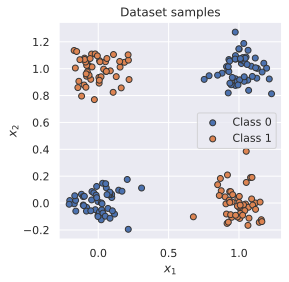

In [42]:
visualize_samples(dataset.data, dataset.label)
plt.show()

In [43]:
# Create simple dataloader
# This collate function is taken from the JAX tutorial with PyTorch Data Loading
# https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=numpy_collate)


In [44]:
# next(iter(...)) catches the first batch of the data loader
# If shuffle is True, this will return a different batch every time we run this cell
# For iterating over the whole dataset, we can simple use "for batch in data_loader: ..."
data_inputs, data_labels = next(iter(data_loader))

# The shape of the outputs are [batch_size, d_1,...,d_N] where d_1,...,d_N are the
# dimensions of the data point returned from the dataset class
print("Data inputs", data_inputs.shape, "\n", data_inputs)
print("Data labels", data_labels.shape, "\n", data_labels)

Data inputs (8, 2) 
 [[-0.00190162 -0.10025293]
 [-0.02176812  1.1098777 ]
 [-0.16694053  0.05433602]
 [ 1.0173181   1.0385318 ]
 [ 1.0341756   1.1876171 ]
 [ 0.8799704   0.9665499 ]
 [ 0.8484809   0.13668743]
 [-0.17033824 -0.00555477]]
Data labels (8,) 
 [0 1 0 0 0 0 1 0]


In [45]:
try:
    import optax
except ModuleNotFoundError: # Install optax if missing
    !pip install --quiet optax
    import optax

In [46]:
# Input to the optimizer are optimizer settings like learning rate
optimizer = optax.sgd(learning_rate=0.1)

In [47]:
from flax.training import train_state

model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params, 
                                            tx=optimizer)

In [48]:
def calculate_loss_acc(state, params, batch):
  data_input, labels = batch
  # Obtain the logits and predictions of the model for the input data
  logits = state.apply_fn(params, data_input).squeeze(axis=-1)
  pred_labels = (logits > 0).astype(jnp.float32)
  # Calculate the loss and accuracy
  loss = optax.sigmoid_binary_cross_entropy(logits, labels).mean()
  acc = (pred_labels == labels).mean()
  return loss, acc

In [49]:
batch = next(iter(data_loader))
calculate_loss_acc(model_state, model_state.params, batch)

(DeviceArray(0.5644027, dtype=float32), DeviceArray(0.75, dtype=float32))

In [50]:
# Create efficient training and validatation step
@jax.jit
def train_step(state, batch):
  # Gradient function
  grad_fn = jax.value_and_grad(calculate_loss_acc,
                                argnums=1, 
                               has_aux=True)
  
  # Determine gradients for current model, parameters and batch
  (loss, acc), grads = grad_fn(state, state.params, batch)
  # Perform parameter update with gradients and optimzer
  state = state.apply_gradients(grads=grads)
  # Return state and any other value we might want
  return state, loss, acc

In [51]:
@jax.jit  # Jit the function for efficiency
def eval_step(state, batch):
  # Determine the accuracy
  _, acc = calculate_loss_acc(state, state.params, batch)
  return acc

In [52]:
train_dataset = XORDataset(size=2500, seed=42)
train_data_loader = data.DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=numpy_collate)

In [53]:
def train_model(state, data_loader, num_epochs=100):
  # Training loop
  for epoch in tqdm(range(num_epochs)):
    for batch in data_loader:
      state, loss, acc = train_step(state, batch)
      # We could use the loss and accuracy for logging here, e.g. in TensorBoard
      # For simplicity, we skip this part here
  return state

In [54]:
trained_model_state = train_model(model_state, train_data_loader, num_epochs=100)


  0%|          | 0/100 [00:00<?, ?it/s]

In [55]:
from flax.training import checkpoints

checkpoints.save_checkpoint(ckpt_dir='my_checkpoints/',  # Folder to save checkpoint in
                            target=trained_model_state,  # What to save. To only save parameters, use model_state.params
                            step=100,  # Training step or other metric to save best model on
                            prefix='my_model',  # Checkpoint file name prefix
                            overwrite=True   # Overwrite existing checkpoint files
                           )

'my_checkpoints/my_model100'

In [56]:
loaded_model_state = checkpoints.restore_checkpoint(
                                             ckpt_dir='my_checkpoints/',   # Folder with the checkpoints
                                             target=model_state,   # (optional) matching object to rebuild state in
                                             prefix='my_model'  # Checkpoint file name prefix
                                            )

In [57]:
test_dataset = XORDataset(size=500, seed=123)
# drop_last -> Don't drop the last batch although it is smaller than 128
test_data_loader = data.DataLoader(test_dataset,
                                   batch_size=128,
                                   shuffle=False,
                                   drop_last=False,
                                   collate_fn=numpy_collate)

In [58]:
def eval_model(state, data_loader):
    all_accs, batch_sizes = [], []
    for batch in data_loader:
        batch_acc = eval_step(state, batch)
        all_accs.append(batch_acc)
        batch_sizes.append(batch[0].shape[0])
    # Weighted average since some batches might be smaller
    acc = sum([a*b for a,b in zip(all_accs, batch_sizes)]) / sum(batch_sizes)
    print(f"Accuracy of the model: {100.0*acc:4.2f}%")

In [59]:
eval_model(trained_model_state, test_data_loader)

Accuracy of the model: 100.00%


In [60]:
# Binding model parameters
trained_model = model.bind(trained_model_state.params)

In [61]:
data_input, labels = next(iter(data_loader))
out = trained_model(data_input)
print(out.shape)

(8, 1)


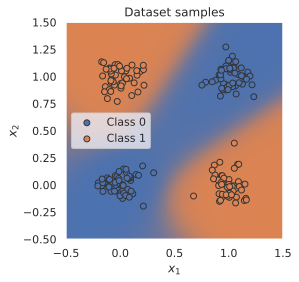

In [62]:
def visualize_classification(model, data, label):
  data_0 = data[label == 0]
  data_1 = data[label == 1]

  fig = plt.figure(figsize=(4,4), dpi=500)
  plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
  plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
  plt.title("Dataset samples")
  plt.ylabel(r"$x_2$")
  plt.xlabel(r"$x_1$")
  plt.legend()

  # Let's make use of a lot of operations we have learned above
  c0 = np.array(to_rgba("C0"))
  c1 = np.array(to_rgba("C1"))
  x1 = jnp.arange(-0.5, 1.5, step=0.01)
  x2 = jnp.arange(-0.5, 1.5, step=0.01)
  xx1, xx2 = jnp.meshgrid(x1, x2, indexing='ij')  # Meshgrid function as in numpy
  model_inputs = np.stack([xx1, xx2], axis=-1)
  logits = model(model_inputs)
  preds = nn.sigmoid(logits)
  output_image = (1 - preds) * c0[None,None] + preds * c1[None,None]  # Specifying "None" in a dimension creates a new one
  output_image = jax.device_get(output_image)  # Convert to numpy array. This only works for tensors on CPU, hence first push to CPU
  plt.imshow(output_image, origin='lower', extent=(-0.5, 1.5, -0.5, 1.5))
  plt.grid(False)
  return fig

_ = visualize_classification(trained_model, dataset.data, dataset.label)
plt.show()